# 1. Sinh dữ liệu (Data Generation)

In [23]:
import random
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# --- Cấu hình thời gian ---
start_date = datetime(2022, 1, 1)
end_date = start_date + timedelta(days=365)
interval = timedelta(minutes=15)


# Tạo home_id từ 1 đến 10
home_ids = list(range(1, 11))

# Tạo mảng delta_time với các giá trị ngẫu nhiên từ 0 đến 60 cho mỗi home_id
delta_times = [random.randint(0, 60) for _ in home_ids]

# Tạo DataFrame từ home_id và delta_time
home_data = pd.DataFrame({
    'home_id': home_ids,
    'delta_time': delta_times
})



# --- Cấu hình thiết bị ---
devices = [
    {'device_id': 'AC_01', 'device_type': 'air_conditioner', 'room': 'bedroom'},
    {'device_id': 'LIGHT_01', 'device_type': 'light', 'room': 'living_room'},
    {'device_id': 'TV_01', 'device_type': 'tv', 'room': 'living_room'},
    {'device_id': 'FRIDGE_01', 'device_type': 'fridge', 'room': 'kitchen'},
    {'device_id': 'WASHER_01', 'device_type': 'washer', 'room': 'laundry_room'},
]

import random

# --- Hàm xác định hành vi người dùng có biến đổi theo ngày ---
def get_user_state(timestamp, delta_m, home_id):
    hour = timestamp.hour + timestamp.minute/60 + delta_m/60 + random.uniform(-1, 0.5)
    weekday = timestamp.weekday()  # 0=Thứ 2, 6=Chủ nhật

    # Tạo sự dao động theo ngày trong tuần (vd: thứ 2 dậy sớm hơn, CN dậy muộn)
    daily_offset = {
        0: -0.5,  # Monday: dậy sớm hơn
        1: -0.2,
        2: 0.0,
        3: 0.2,
        4: 0.3,
        5: 0.5,
        6: 0.7   # Sunday: dậy muộn hơn
    }
    hour += daily_offset.get(weekday, 0)

    # 20% nhà luôn có người
    always_home = [1, 2]
    if home_id in always_home:
        if 0 <= hour < 6.5 or hour >= 22.5:
            return 1, 'sleeping'
        elif 6.5 <= hour < 8 or 17 <= hour < 19.5:
            return 1, 'cooking'
        elif 9 <= hour < 22.5:
            return 1, 'watching_tv'
        else:
            return 1, 'idle'

    # Các nhà còn lại
    if weekday >= 5:  # Cuối tuần
        if 0 <= hour < 7.5 or hour >= 23:
            return 1, 'sleeping'
        elif 7.5 <= hour < 9 or 17 <= hour < 20:
            return 1, 'cooking'
        elif 19 <= hour < 23:
            return 1, 'watching_tv'
        else:
            return 1, 'idle'
    else:  # Trong tuần
        if 0 <= hour < 6.5 or hour >= 22.5:
            return 1, 'sleeping'
        elif 6.5 <= hour < 8 or 17 <= hour < 19.5:
            return 1, 'cooking'
        elif 8 <= hour < 17:
            return 0, 'away'
        elif 19 <= hour < 22.5:
            return 1, 'watching_tv'
        else:
            return 1, 'idle'


# Thời gian mặt trời mọc và lặn (theo tháng)
sun_times = {
    1: (6.5, 17.5), 2: (6.33, 17.75), 3: (6.0, 18.0), 4: (5.5, 18.25),
    5: (5.33, 18.5), 6: (5.25, 18.67), 7: (5.42, 18.58), 8: (5.58, 18.33),
    9: (5.75, 18.0), 10: (6.0, 17.75), 11: (6.25, 17.5), 12: (6.5, 17.33)
}

# Hàm sinh môi trường có yếu tố thay đổi theo mùa
def generate_environment(timestamp):

    noise_rain = random.uniform(0, 1)
    month = timestamp.month
    hour = timestamp.hour
    day_of_year = timestamp.timetuple().tm_yday

    base_month = [0, 15, 16, 19, 23, 28, 30, 31, 30, 28, 25, 21, 17]
    delta_month = [0, 4, 4.5, 5.2, 6, 7.8, 9.2, 9.3, 8.5, 7.9, 6.4, 5, 4]
    random_factors = [0, 6.2, 5.5, 6.4, 7.3, 7.9, 8.4, 9.6, 9.4, 8.9, 7.5, 7, 6.6]


    outdoor_temp = 23 + 8 * np.sin(2 * np.pi * (day_of_year - 98) / 365) + \
                   delta_month[month] * np.sin(((hour - random_factors[month]) / 24) * 2 * np.pi) + \
                   random.uniform(-1, 1)
    if noise_rain > 0.7:
          outdoor_temp -= 6

    indoor_temp = outdoor_temp + random.uniform(-2, 2)
    humidity = 60 - 0.4 * outdoor_temp + random.uniform(-20, 20)
    if noise_rain > 0.7:
          humidity = min(100, humidity + 30)

    sunrise, sunset = sun_times[month]
    if sunrise <= hour <= sunset:
        day_length = sunset - sunrise
        time_since_sunrise = hour - sunrise
        sun_ratio = np.sin((time_since_sunrise / day_length) * np.pi)
        light_level = 100 * (7 + 3*np.sin(2 * np.pi * (day_of_year - 98) / 365)) * sun_ratio
        light_level = max(0, light_level)
    else:
        light_level = random.uniform(0, 100)

    return round(indoor_temp, 1), round(outdoor_temp, 1), round(humidity, 1), round(light_level, 1)

# --- Hàm tính giá điện ---
def get_price_per_kWh(hour):
    if 22 <= hour or hour < 6:
        return 1500
    elif 17 <= hour < 21:
        return 3000
    else:
        return 2500

def get_device_status(home_id, device_type, timestamp, user_present, activity, indoor_temp, light_level):
    power = 0
    status = 'off'
    a = [6, 7, 8, 12, 13, 19, 20, 21, 22, 23]
    noise_on_prob = 0.05
    noise_off_prob = 0.05
    if device_type == 'air_conditioner':
        should_be_on = user_present and indoor_temp >= 28 + random.uniform(-1, 2)
        if (should_be_on and random.random() > noise_off_prob) or \
           (not should_be_on and random.random() < noise_on_prob):
            status = 'on'
            power = random.uniform(700, 800)
            if  indoor_temp >= 28:
                power += ( indoor_temp - 28) * random.uniform(25, 30)

    elif device_type == 'light':
        should_be_on = user_present and light_level < 120 and activity != 'sleeping'
        if (should_be_on and random.random() > noise_off_prob) or \
           (not should_be_on and random.random() < noise_on_prob):
            status = 'on'
            power = random.uniform(100, 200)

    elif device_type == 'tv':
        should_be_on = user_present and activity == 'watching_tv'
        if (should_be_on and random.random() > noise_off_prob) or \
           (not should_be_on and random.random() < noise_on_prob):
            status = 'on'
            power = random.uniform(300, 410)

    elif device_type == 'fridge':
        status = 'on'
        power = random.uniform(200, 310)
        if  indoor_temp >= 28:
                power -= ( indoor_temp - 28) * random.uniform(5, 10)

    elif device_type == 'washer':
        should_be_on = user_present and (timestamp.hour == a[home_id - 1])
        if (should_be_on and random.random() > noise_off_prob) or \
           (not should_be_on and random.random() < noise_on_prob):
            status = 'on'
            power = random.uniform(650, 760)

    return status, round(power, 2)




# --- Sinh dữ liệu ---
data = []
timestamp = start_date
while timestamp < end_date:
    for i in range(len(home_data)):
        home_id = home_data['home_id'][i]
        delta_m = home_data['delta_time'][i]

        user_present, activity = get_user_state(timestamp, delta_m, home_id)
        indoor_temp, outdoor_temp, humidity, light_level = generate_environment(timestamp)
        price_kWh = get_price_per_kWh(timestamp.hour)

        for device in devices:
            status, power = get_device_status(
                home_id, device['device_type'], timestamp,
                user_present, activity, indoor_temp, light_level
            )

            data.append({
                'home_id': home_id,
                'timestamp': timestamp,
                'device_id': device['device_type'] + str(home_id),
                'device_type': device['device_type'],
                'room': device['room'],
                'status': status,
                'power_watt': power,
                'user_present': user_present,
                'activity': activity,
                'indoor_temp': indoor_temp,
                'outdoor_temp': outdoor_temp,
                'humidity': humidity,
                'light_level': light_level,
                'day_of_week': timestamp.weekday(),
                'hour_of_day': timestamp.hour,
                'price_kWh': price_kWh
            })
    timestamp += interval

# --- Thêm 2% ngoại lệ ---
num_records = len(data)
num_anomalies = int(0.02 * num_records)
anomalous_indices = random.sample(range(num_records), num_anomalies)
for idx in anomalous_indices:
    data[idx]['power_watt'] *= random.uniform(3, 5)

# --- Lưu file ---
df = pd.DataFrame(data)
df.to_csv("data_2022.csv", index=False)


In [5]:
df

,home_id,timestamp,device_id,device_type,room,status,power_watt,user_present,activity,indoor_temp,outdoor_temp,humidity,light_level,day_of_week,hour_of_day,price_kWh
0,1,2022-01-01 00:00:00,air_conditioner1,air_conditioner,bedroom,off,0.00,1,sleeping,9.9,11.6,53.2,56.4,5,0,1500
1,1,2022-01-01 00:00:00,light1,light,living_room,off,0.00,1,sleeping,9.9,11.6,53.2,56.4,5,0,1500
2,1,2022-01-01 00:00:00,tv1,tv,living_room,off,0.00,1,sleeping,9.9,11.6,53.2,56.4,5,0,1500
3,1,2022-01-01 00:00:00,fridge1,fridge,kitchen,on,260.79,1,sleeping,9.9,11.6,53.2,56.4,5,0,1500
4,1,2022-01-01 00:00:00,washer1,washer,laundry_room,off,0.00,1,sleeping,9.9,11.6,53.2,56.4,5,0,1500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1751995,10,2022-12-31 23:45:00,air_conditioner10,air_conditioner,bedroom,off,0.00,1,sleeping,10.3,11.9,50.7,66.6,5,23,1500
1751996,10,2022-12-31 23:45:00,light10,light,living_room,on,122.17,1,sleeping,10.3,11.9,50.7,66.6,5,23,1500
1751997,10,2022-12-31 23:45:00,tv10,tv,living_room,off,0.00,1,sleeping,10.3,11.9,50.7,66.6,5,23,1500
1751998,10,2022-12-31 23:45:00,fridge10,fridge,kitchen,on,260.57,1,sleeping,10.3,11.9,50.7,66.6,5,23,1500


# 2. Phân tích dữ liệu (Exploratory Data Analysis)

In [81]:
df = pd.read_csv('data_2022.csv')

##2,1. Công suất tiêu thụ của các thiết bị và thói quen sinh hoạt người dùng

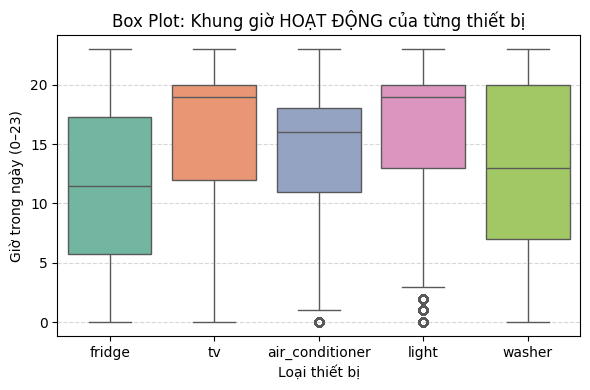

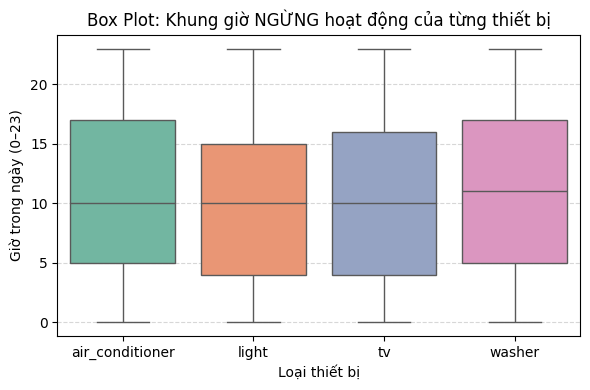

In [82]:
#@title Box plot trạng thái hoạt động của các thiết bị
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_on = df[df['status'] == 'on']

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_on, x='device_type', y='hour_of_day', hue='device_type', palette='Set2', legend=False)
plt.title("Box Plot: Khung giờ HOẠT ĐỘNG của từng thiết bị")
plt.ylabel("Giờ trong ngày (0–23)")
plt.xlabel("Loại thiết bị")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

df_on = df[df['status'] == 'off']

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_on, x='device_type', y='hour_of_day', hue='device_type', palette='Set2', legend=False)
plt.title("Box Plot: Khung giờ NGỪNG hoạt động của từng thiết bị")
plt.ylabel("Giờ trong ngày (0–23)")
plt.xlabel("Loại thiết bị")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

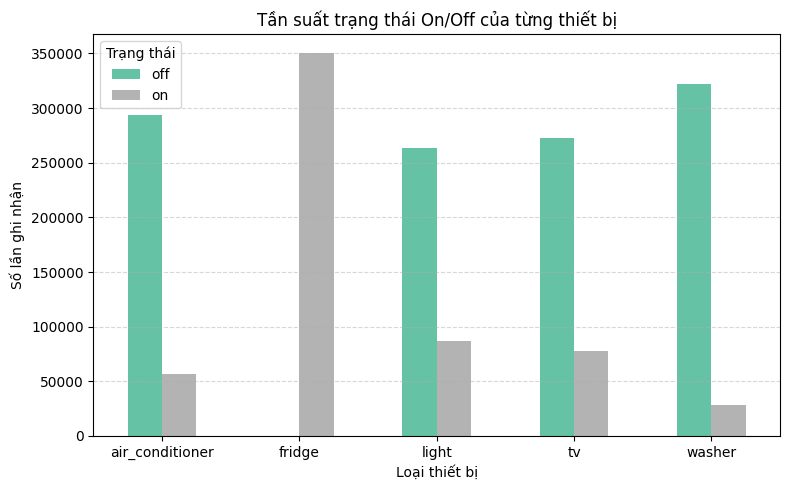

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Nhóm dữ liệu theo loại thiết bị và trạng thái (on/off), sau đó đếm số lượng
frequency_table = df.groupby(['device_type', 'status']).size().unstack(fill_value=0)

# Vẽ biểu đồ cột
frequency_table.plot(kind='bar', figsize=(8, 5), colormap='Set2')

# Tùy chỉnh biểu đồ
plt.title("Tần suất trạng thái On/Off của từng thiết bị")
plt.xlabel("Loại thiết bị")
plt.ylabel("Số lần ghi nhận")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.legend(title='Trạng thái')
plt.tight_layout()
plt.show()


Công suất tiêu thụ trung bình khi thiết bị hoạt động (ON):
     Loại thiết bị  Công suất trung bình (W)
0  air_conditioner                913.485134
1           fridge                261.573805
2            light                158.604781
3               tv                377.292172
4           washer                751.966337


<ipython-input-84-9ab7660abdaf>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_power_by_device, x='Loại thiết bị', y='Công suất trung bình (W)', palette='Set2')


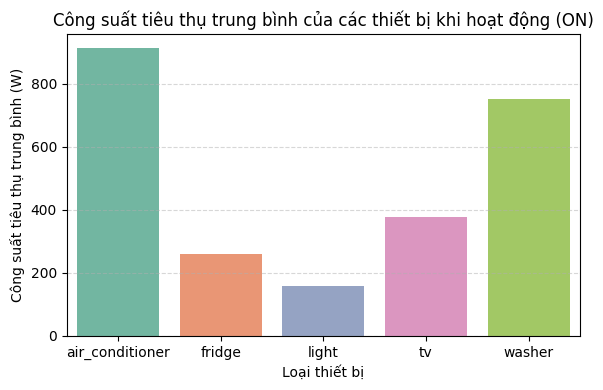

In [84]:
#@title Công suất trung bình của các thiết bị khi hoạt động (ON)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Lọc các bản ghi có trạng thái 'on'
df_on = df[df['status'] == 'on']

# Tính công suất tiêu thụ trung bình theo loại thiết bị
avg_power_by_device = df_on.groupby('device_type')['power_watt'].mean().reset_index()

# Đổi tên cột cho rõ ràng hơn
avg_power_by_device.columns = ['Loại thiết bị', 'Công suất trung bình (W)']

# Hiển thị bảng kết quả
print("Công suất tiêu thụ trung bình khi thiết bị hoạt động (ON):")
print(avg_power_by_device)

# Vẽ biểu đồ cột
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_power_by_device, x='Loại thiết bị', y='Công suất trung bình (W)', palette='Set2')
plt.title("Công suất tiêu thụ trung bình của các thiết bị khi hoạt động (ON)")
plt.ylabel("Công suất tiêu thụ trung bình (W)")
plt.xlabel("Loại thiết bị")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

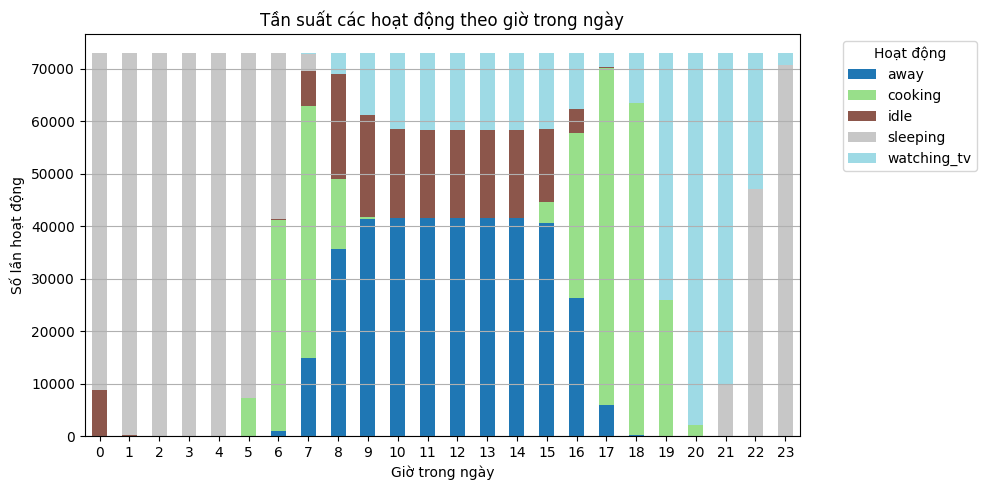

In [85]:
#@title Tần suất các hoạt động theo ngày
import pandas as pd
import matplotlib.pyplot as plt

# Tạo cột 'hour_of_day' từ timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour_of_day'] = df['timestamp'].dt.hour

# Đếm tần suất xuất hiện của từng activity theo giờ
activity_per_hour = df.groupby(['hour_of_day', 'activity']).size().unstack(fill_value=0)

# Vẽ stacked bar chart: hoạt động theo giờ
plt.figure(figsize=(10, 5))
activity_per_hour.plot(kind='bar', stacked=True, colormap='tab20', figsize=(10, 5))
plt.title("Tần suất các hoạt động theo giờ trong ngày")
plt.xlabel("Giờ trong ngày")
plt.ylabel("Số lần hoạt động")
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.legend(title='Hoạt động', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


##2.2. Yếu tố môi trường

In [86]:
df = pd.read_csv('data_2022.csv')

###2.2.1. Nhiệt độ

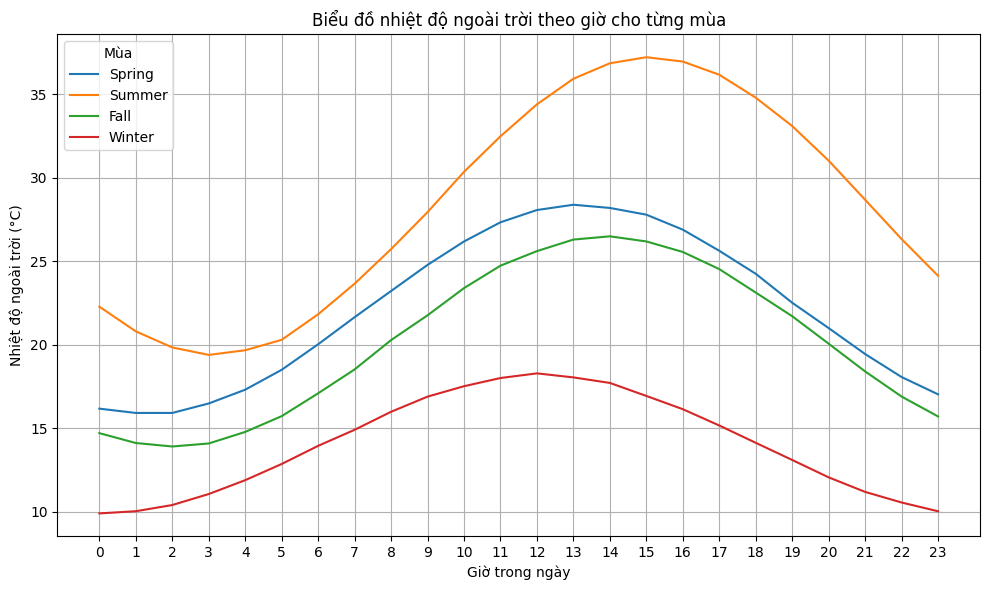

In [87]:
#@title Biểu đồ nhiệt độ ngoài trời theo giờ cho từng mùa
import pandas as pd
import matplotlib.pyplot as plt

# Giả sử df đã có cột 'hour_of_day', 'outdoor_temp', và 'timestamp'

# Chuyển đổi cột 'timestamp' nếu chưa phải kiểu datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Thêm cột 'month' và 'season' để xác định mùa
df['month'] = df['timestamp'].dt.month
df['season'] = df['month'].apply(lambda x: 'Spring' if 3 <= x <= 5 else
                                             ('Summer' if 6 <= x <= 8 else
                                              ('Fall' if 9 <= x <= 11 else 'Winter')))

# --- Vẽ biểu đồ cho từng mùa ---
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

plt.figure(figsize=(10, 6))

for season in seasons:
    # Lọc dữ liệu theo mùa
    df_season = df[df['season'] == season]

    # Tính toán nhiệt độ trung bình theo giờ
    avg_temp_per_hour = df_season.groupby('hour_of_day')['outdoor_temp'].mean()

    # Vẽ biểu đồ cho từng mùa
    plt.plot(avg_temp_per_hour.index, avg_temp_per_hour.values, label=season)

plt.title("Biểu đồ nhiệt độ ngoài trời theo giờ cho từng mùa")
plt.xlabel("Giờ trong ngày")
plt.ylabel("Nhiệt độ ngoài trời (°C)")
plt.grid(True)
plt.xticks(range(0, 24, 1))  # Đặt nhãn cho từng giờ trong ngày
plt.legend(title='Mùa', loc='upper left')
plt.tight_layout()
plt.show()


<ipython-input-88-56e28a73ff64>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['timestamp'].dt.date
<ipython-input-88-56e28a73ff64>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['timestamp'].dt.month
<ipython-input-88-56e28a73ff64>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

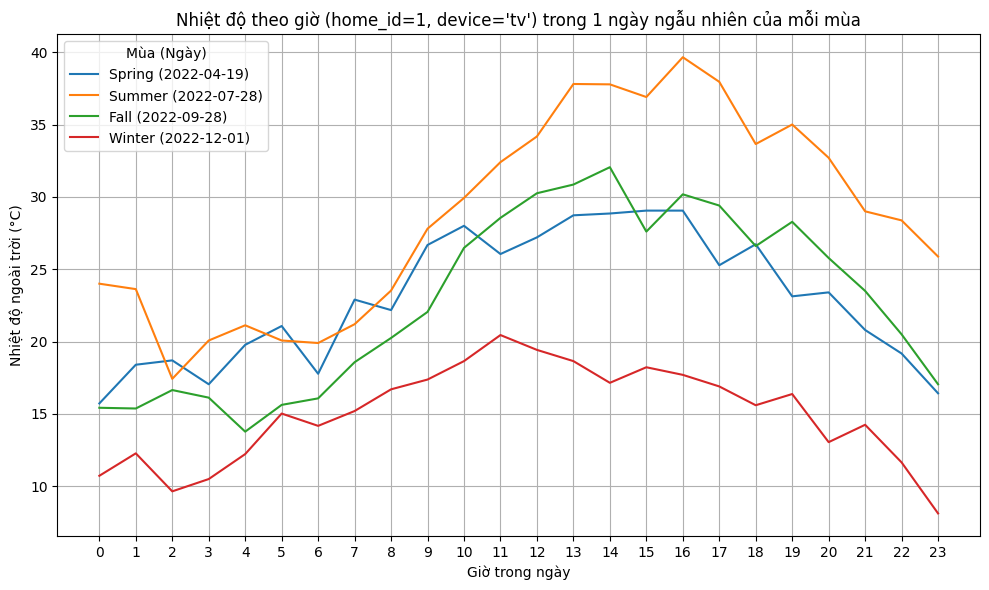

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import random

# Giả sử df đã có các cột: 'home_id', 'device_type', 'hour_of_day', 'outdoor_temp', 'timestamp'

# Chuyển timestamp sang datetime nếu chưa
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Lọc dữ liệu theo điều kiện home_id và device_type
df = df[(df['home_id'] == 1) & (df['device_type'] == 'tv')]

# Thêm cột 'date', 'month', và 'season'
df['date'] = df['timestamp'].dt.date
df['month'] = df['timestamp'].dt.month
df['season'] = df['month'].apply(lambda x: 'Spring' if 3 <= x <= 5 else
                                 ('Summer' if 6 <= x <= 8 else
                                  ('Fall' if 9 <= x <= 11 else 'Winter')))

# Danh sách các mùa
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

plt.figure(figsize=(10, 6))

for season in seasons:
    # Lọc dữ liệu theo mùa
    df_season = df[df['season'] == season]

    # Kiểm tra xem có đủ dữ liệu để chọn ngẫu nhiên không
    unique_days = df_season['date'].unique()
    if len(unique_days) == 0:
        print(f"Không có dữ liệu cho mùa {season}")
        continue

    # Chọn ngẫu nhiên 1 ngày trong mùa
    random_day = random.choice(unique_days)

    # Lọc dữ liệu theo ngày được chọn
    df_day = df_season[df_season['date'] == random_day]

    # Tính nhiệt độ theo giờ trong ngày đó
    temp_per_hour = df_day.groupby('hour_of_day')['outdoor_temp'].mean()

    # Vẽ biểu đồ
    plt.plot(temp_per_hour.index, temp_per_hour.values, label=f"{season} ({random_day})")

# Vẽ biểu đồ
plt.title("Nhiệt độ theo giờ (home_id=1, device='tv') trong 1 ngày ngẫu nhiên của mỗi mùa")
plt.xlabel("Giờ trong ngày")
plt.ylabel("Nhiệt độ ngoài trời (°C)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.legend(title="Mùa (Ngày)", loc='upper left')
plt.tight_layout()
plt.show()


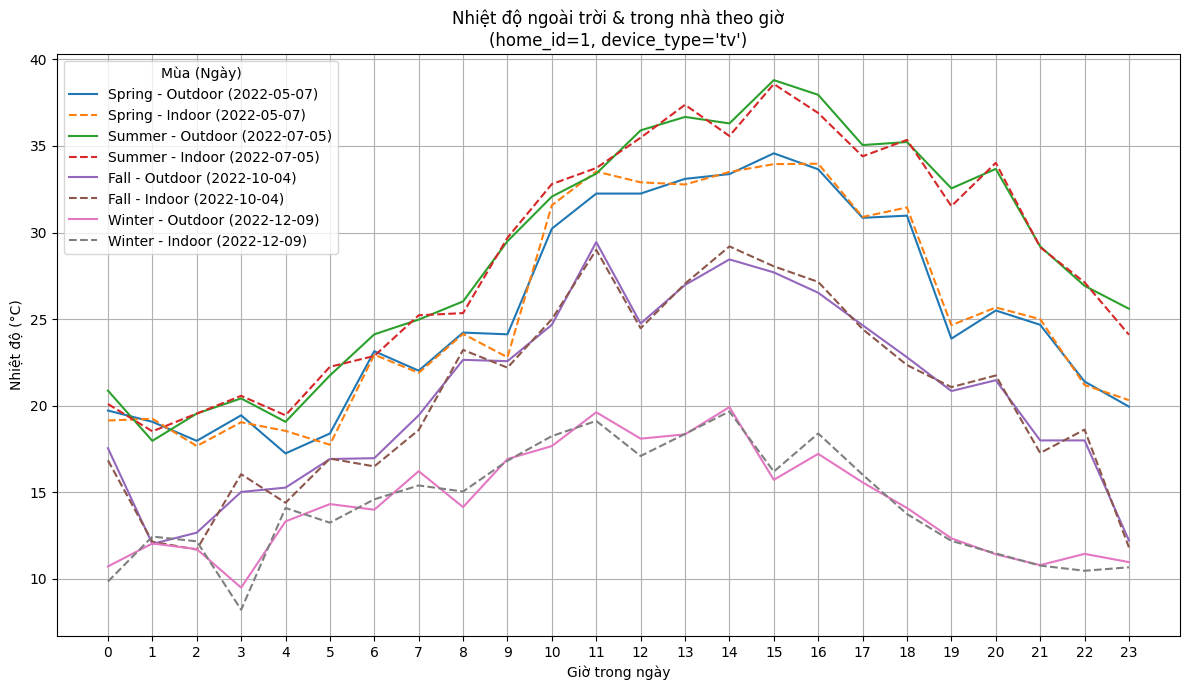

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import random

# Giả sử df đã có các cột: 'home_id', 'device_type', 'hour_of_day',
# 'outdoor_temp', 'indoor_temp', 'timestamp'

# Chuyển đổi timestamp nếu chưa phải datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Lọc dữ liệu theo điều kiện
df = df[(df['home_id'] == 1) & (df['device_type'] == 'tv')]

# Thêm cột 'date', 'month', 'season'
df['date'] = df['timestamp'].dt.date
df['month'] = df['timestamp'].dt.month
df['season'] = df['month'].apply(lambda x: 'Spring' if 3 <= x <= 5 else
                                 ('Summer' if 6 <= x <= 8 else
                                  ('Fall' if 9 <= x <= 11 else 'Winter')))

# Danh sách các mùa
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

# Vẽ biểu đồ cho từng mùa
plt.figure(figsize=(12, 7))

for season in seasons:
    df_season = df[df['season'] == season]
    unique_days = df_season['date'].unique()

    if len(unique_days) == 0:
        print(f"⚠️ Không có dữ liệu cho mùa {season}")
        continue

    # Chọn ngẫu nhiên một ngày trong mùa
    random_day = random.choice(unique_days)
    df_day = df_season[df_season['date'] == random_day]

    # Tính nhiệt độ trung bình mỗi giờ cho cả indoor và outdoor
    hourly_avg = df_day.groupby('hour_of_day')[['outdoor_temp', 'indoor_temp']].mean()

    # Vẽ hai đường biểu diễn
    plt.plot(hourly_avg.index, hourly_avg['outdoor_temp'], label=f"{season} - Outdoor ({random_day})")
    plt.plot(hourly_avg.index, hourly_avg['indoor_temp'], linestyle='--', label=f"{season} - Indoor ({random_day})")

# Thiết lập biểu đồ
plt.title("Nhiệt độ ngoài trời & trong nhà theo giờ\n(home_id=1, device_type='tv')")
plt.xlabel("Giờ trong ngày")
plt.ylabel("Nhiệt độ (°C)")
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title="Mùa (Ngày)", loc='upper left')
plt.tight_layout()
plt.show()


###2.2.2. Ánh sáng

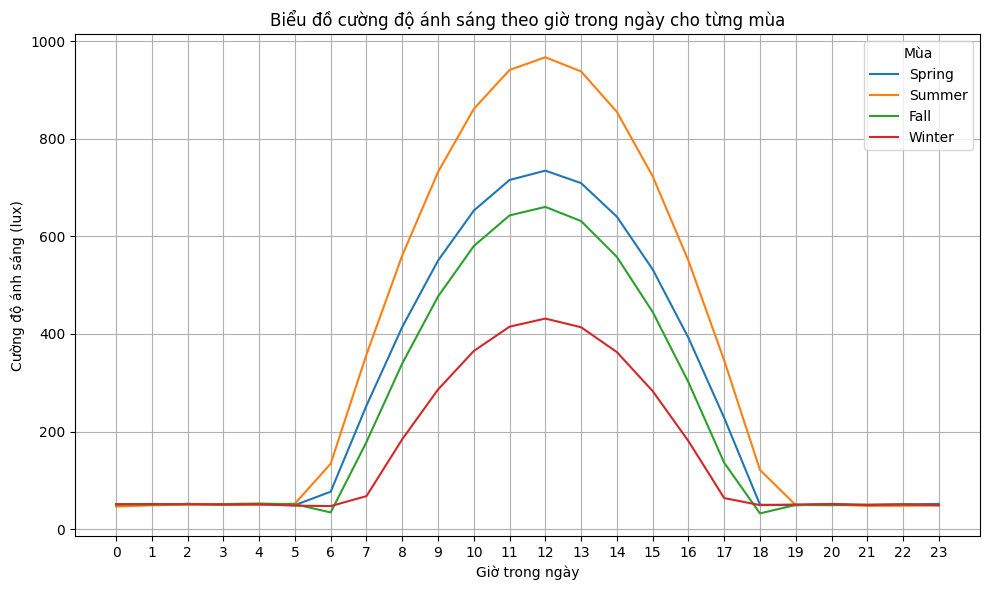

In [90]:
#@title Biểu đồ cường độ ánh sáng theo giờ trong ngày cho từng mùa
import pandas as pd
import matplotlib.pyplot as plt

# Giả sử df đã có cột 'hour_of_day', 'light_level', và 'timestamp'

# Chuyển đổi timestamp sang datetime nếu cần
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Thêm cột 'month' và 'season'
df['month'] = df['timestamp'].dt.month
df['season'] = df['month'].apply(lambda x: 'Spring' if 3 <= x <= 5 else
                                             ('Summer' if 6 <= x <= 8 else
                                              ('Fall' if 9 <= x <= 11 else 'Winter')))

# --- Vẽ biểu đồ cường độ ánh sáng theo giờ cho từng mùa ---
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

plt.figure(figsize=(10, 6))

for season in seasons:
    # Lọc dữ liệu theo mùa
    df_season = df[df['season'] == season]

    # Tính trung bình cường độ ánh sáng theo giờ
    avg_light_per_hour = df_season.groupby('hour_of_day')['light_level'].mean()

    # Vẽ biểu đồ
    plt.plot(avg_light_per_hour.index, avg_light_per_hour.values, label=season)

plt.title("Biểu đồ cường độ ánh sáng theo giờ trong ngày cho từng mùa")
plt.xlabel("Giờ trong ngày")
plt.ylabel("Cường độ ánh sáng (lux)")
plt.grid(True)
plt.xticks(range(0, 24, 1))
plt.legend(title='Mùa', loc='upper right')
plt.tight_layout()
plt.show()


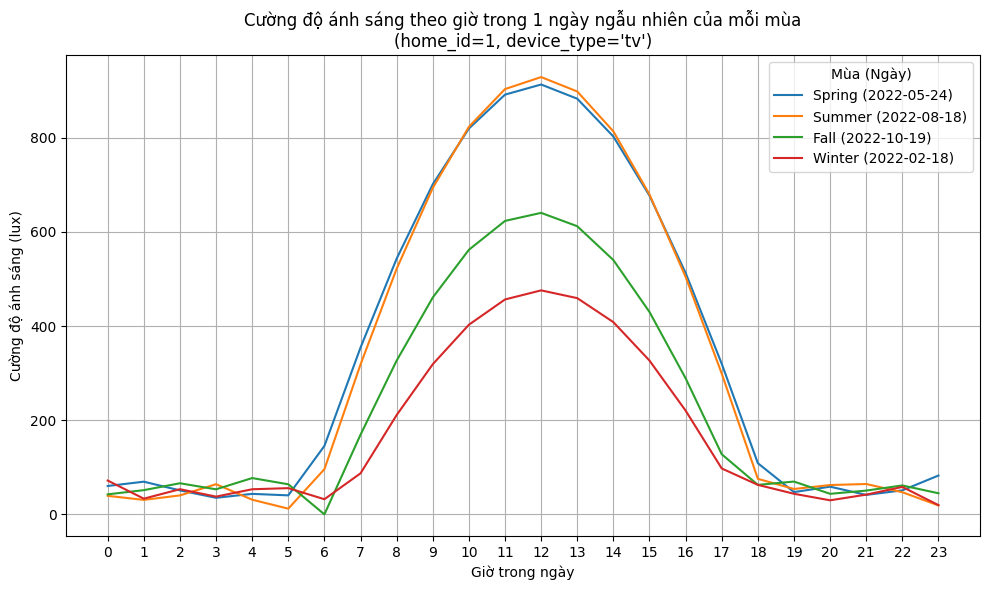

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import random

# Giả sử df đã có các cột: 'home_id', 'device_type', 'timestamp', 'hour_of_day', 'light_level'

# Chuyển timestamp sang datetime nếu cần
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Lọc theo home_id và device_type nếu có trong dữ liệu ánh sáng
df = df[(df['home_id'] == 1) & (df['device_type'] == 'tv')]

# Thêm cột 'date', 'month', 'season'
df['date'] = df['timestamp'].dt.date
df['month'] = df['timestamp'].dt.month
df['season'] = df['month'].apply(lambda x: 'Spring' if 3 <= x <= 5 else
                                 ('Summer' if 6 <= x <= 8 else
                                  ('Fall' if 9 <= x <= 11 else 'Winter')))

# Danh sách mùa
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

for season in seasons:
    df_season = df[df['season'] == season]
    unique_days = df_season['date'].unique()

    if len(unique_days) == 0:
        print(f"⚠️ Không có dữ liệu ánh sáng cho mùa {season}")
        continue

    # Chọn ngẫu nhiên một ngày trong mùa
    random_day = random.choice(unique_days)
    df_day = df_season[df_season['date'] == random_day]

    # Tính trung bình cường độ ánh sáng theo giờ trong ngày đó
    light_per_hour = df_day.groupby('hour_of_day')['light_level'].mean()

    # Vẽ đường biểu diễn
    plt.plot(light_per_hour.index, light_per_hour.values, label=f"{season} ({random_day})")

# Thiết lập biểu đồ
plt.title("Cường độ ánh sáng theo giờ trong 1 ngày ngẫu nhiên của mỗi mùa\n(home_id=1, device_type='tv')")
plt.xlabel("Giờ trong ngày")
plt.ylabel("Cường độ ánh sáng (lux)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.legend(title="Mùa (Ngày)", loc='upper right')
plt.tight_layout()
plt.show()


## 2.3. Thói quen sử dụng thiết bị theo ngày

In [99]:
df = pd.read_csv('data_2022.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

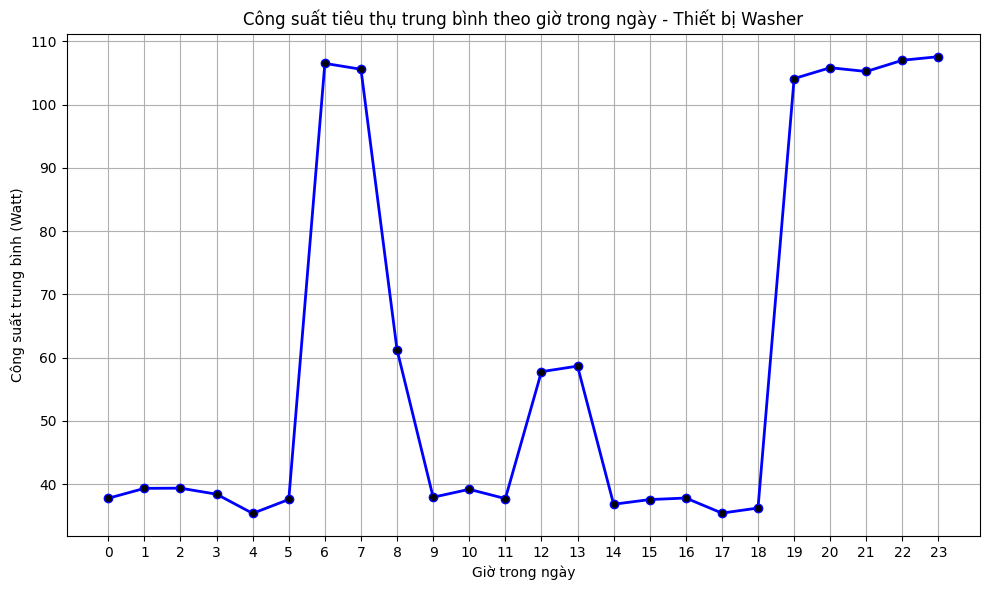

In [100]:
#@title 2.3.1 Công suất tiêu thụ trung bình theo giờ trong ngày - Thiết bị Washer
import pandas as pd
import matplotlib.pyplot as plt

# Giả sử df là DataFrame đã đọc từ CSV, có 'timestamp', 'device_type', 'power_watt'
# Lọc thiết bị là 'washer'
washer_df = df[df['device_type'] == 'washer'].copy()

# Tạo thêm cột giờ trong ngày
washer_df['hour_of_day'] = washer_df['timestamp'].dt.hour

# Tính trung bình công suất theo giờ trong ngày
avg_power_per_hour = washer_df.groupby('hour_of_day')['power_watt'].mean()

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(avg_power_per_hour.index, avg_power_per_hour.values, color='blue', marker='o', markerfacecolor='black', linewidth=2)
plt.title("Công suất tiêu thụ trung bình theo giờ trong ngày - Thiết bị Washer")
plt.xlabel("Giờ trong ngày")
plt.ylabel("Công suất trung bình (Watt)")
plt.xticks(range(0, 24))  # hiển thị đầy đủ các giờ từ 0 đến 23
plt.grid(True)
plt.tight_layout()
plt.show()


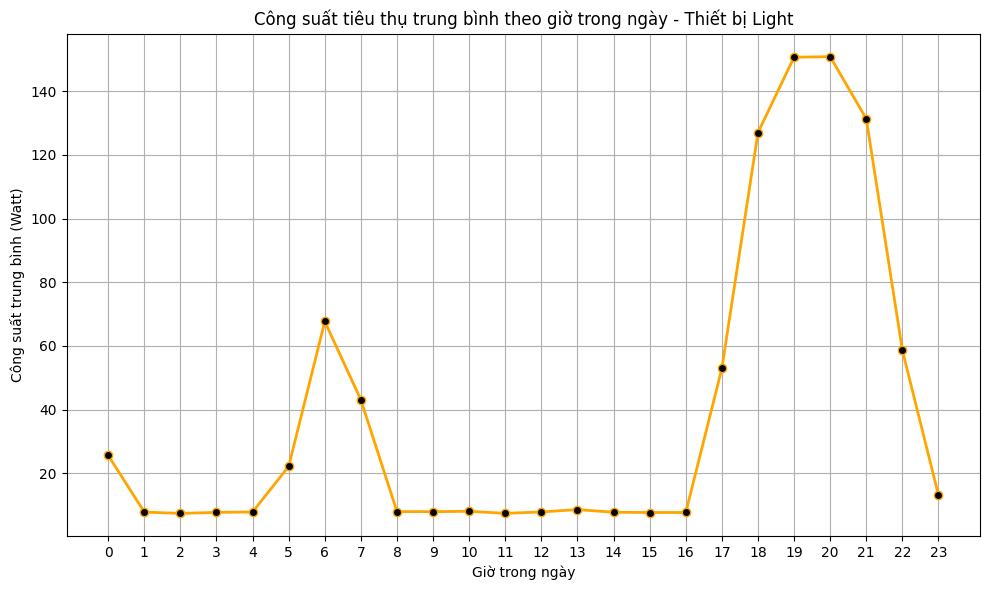

In [101]:
#@title 2.3.2. Công suất tiêu thụ trung bình theo giờ trong ngày - Thiết bị Light
import pandas as pd
import matplotlib.pyplot as plt

# Lọc thiết bị là 'light'
light_df = df[df['device_type'] == 'light'].copy()

# Tạo thêm cột giờ trong ngày
light_df['hour_of_day'] = light_df['timestamp'].dt.hour

# Tính trung bình công suất theo giờ trong ngày
avg_power_per_hour = light_df.groupby('hour_of_day')['power_watt'].mean()

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(avg_power_per_hour.index, avg_power_per_hour.values,
         color='orange', marker='o', markerfacecolor='black', linewidth=2)
plt.title("Công suất tiêu thụ trung bình theo giờ trong ngày - Thiết bị Light")
plt.xlabel("Giờ trong ngày")
plt.ylabel("Công suất trung bình (Watt)")
plt.xticks(range(0, 24))  # hiển thị đầy đủ các giờ từ 0 đến 23
plt.grid(True)
plt.tight_layout()
plt.show()


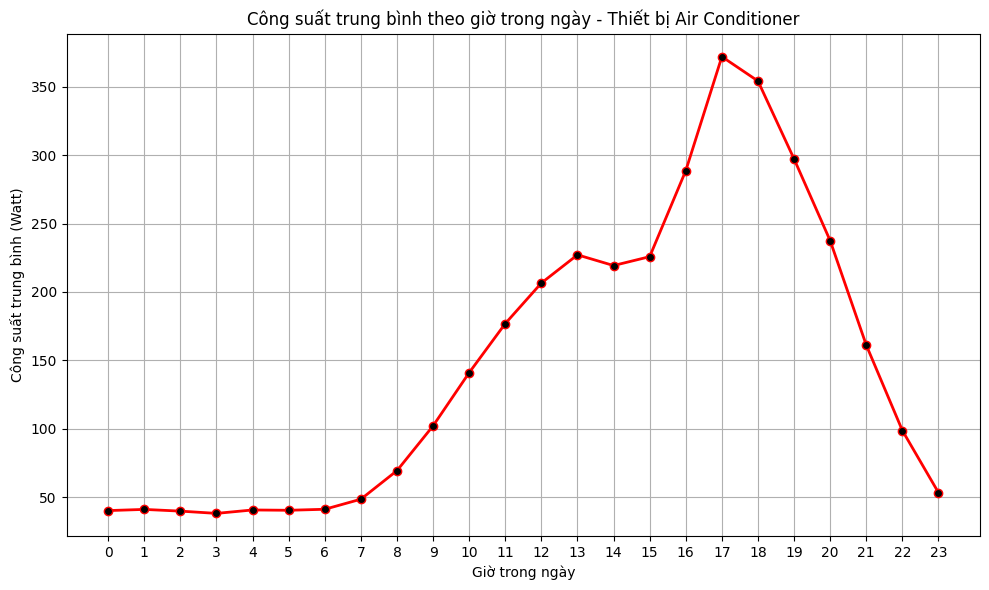

In [102]:
#@title 2.3.3. Công suất trung bình theo giờ trong ngày - Thiết bị Air Conditioner
import pandas as pd
import matplotlib.pyplot as plt

# Lọc thiết bị là 'air_conditioner'
air_conditioner_df = df[df['device_type'] == 'air_conditioner'].copy()

# Tạo thêm cột giờ trong ngày
air_conditioner_df['hour_of_day'] = air_conditioner_df['timestamp'].dt.hour

# Tính trung bình công suất theo giờ trong ngày
avg_power_per_hour = air_conditioner_df.groupby('hour_of_day')['power_watt'].mean()

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(avg_power_per_hour.index, avg_power_per_hour.values,
         color='red', marker='o', markerfacecolor='black', linewidth=2)
plt.title("Công suất trung bình theo giờ trong ngày - Thiết bị Air Conditioner")
plt.xlabel("Giờ trong ngày")
plt.ylabel("Công suất trung bình (Watt)")
plt.xticks(range(0, 24))  # hiển thị đầy đủ các giờ từ 0 đến 23
plt.grid(True)
plt.tight_layout()
plt.show()


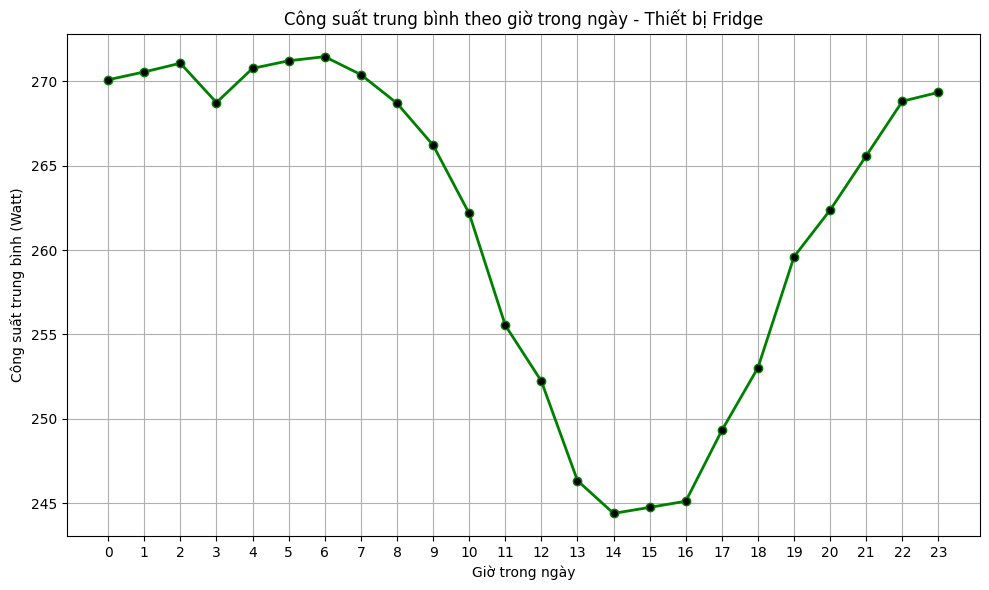

In [103]:
#@title 2.3.4. Công suất trung bình theo giờ trong ngày - Thiết bị Fridge
import pandas as pd
import matplotlib.pyplot as plt

# Lọc thiết bị là 'fridge'
fridge_df = df[df['device_type'] == 'fridge'].copy()

# Tạo thêm cột giờ trong ngày
fridge_df['hour_of_day'] = fridge_df['timestamp'].dt.hour

# Tính trung bình công suất theo giờ trong ngày
avg_power_per_hour = fridge_df.groupby('hour_of_day')['power_watt'].mean()

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(avg_power_per_hour.index, avg_power_per_hour.values,
         color='green', marker='o', markerfacecolor='black', linewidth=2)
plt.title("Công suất trung bình theo giờ trong ngày - Thiết bị Fridge")
plt.xlabel("Giờ trong ngày")
plt.ylabel("Công suất trung bình (Watt)")
plt.xticks(range(0, 24))  # hiển thị đầy đủ các giờ từ 0 đến 23
plt.grid(True)
plt.tight_layout()
plt.show()


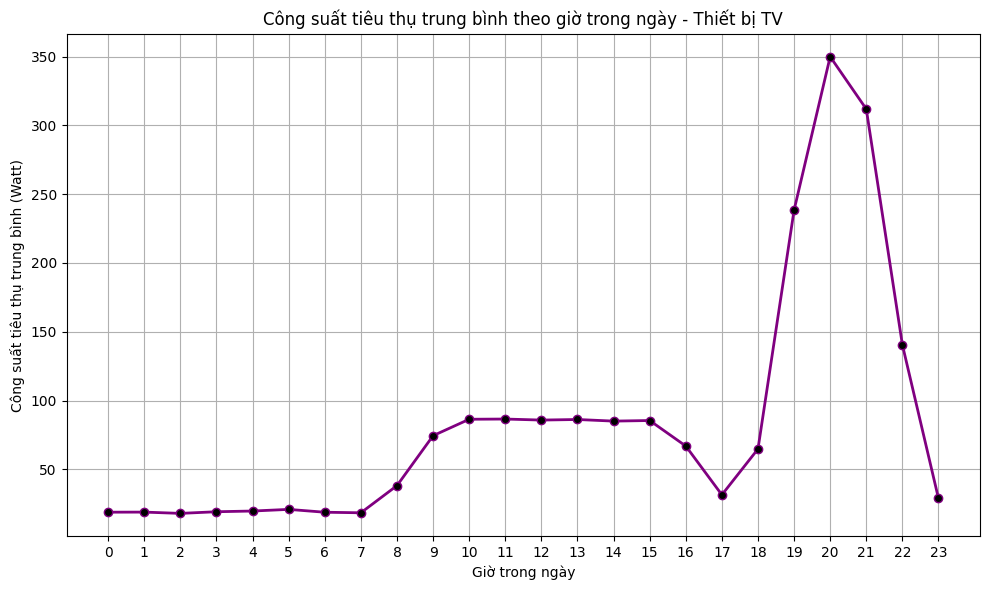

In [104]:
#@title 2.3.5. Công suất tiêu thụ trung bình theo giờ trong ngày - Thiết bị TV
import pandas as pd
import matplotlib.pyplot as plt

# Lọc thiết bị là 'tv'
tv_df = df[df['device_type'] == 'tv'].copy()

# Tạo thêm cột giờ trong ngày
tv_df['hour_of_day'] = tv_df['timestamp'].dt.hour

# Tính trung bình công suất theo giờ trong ngày
avg_power_per_hour = tv_df.groupby('hour_of_day')['power_watt'].mean()

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(avg_power_per_hour.index, avg_power_per_hour.values,
         color='purple', marker='o', markerfacecolor='black', linewidth=2)
plt.title("Công suất tiêu thụ trung bình theo giờ trong ngày - Thiết bị TV")
plt.xlabel("Giờ trong ngày")
plt.ylabel("Công suất tiêu thụ trung bình (Watt)")
plt.xticks(range(0, 24))  # hiển thị đầy đủ các giờ từ 0 đến 23
plt.grid(True)
plt.tight_layout()
plt.show()


## 2.4. Thói quen sử dụng thiết bị theo mùa

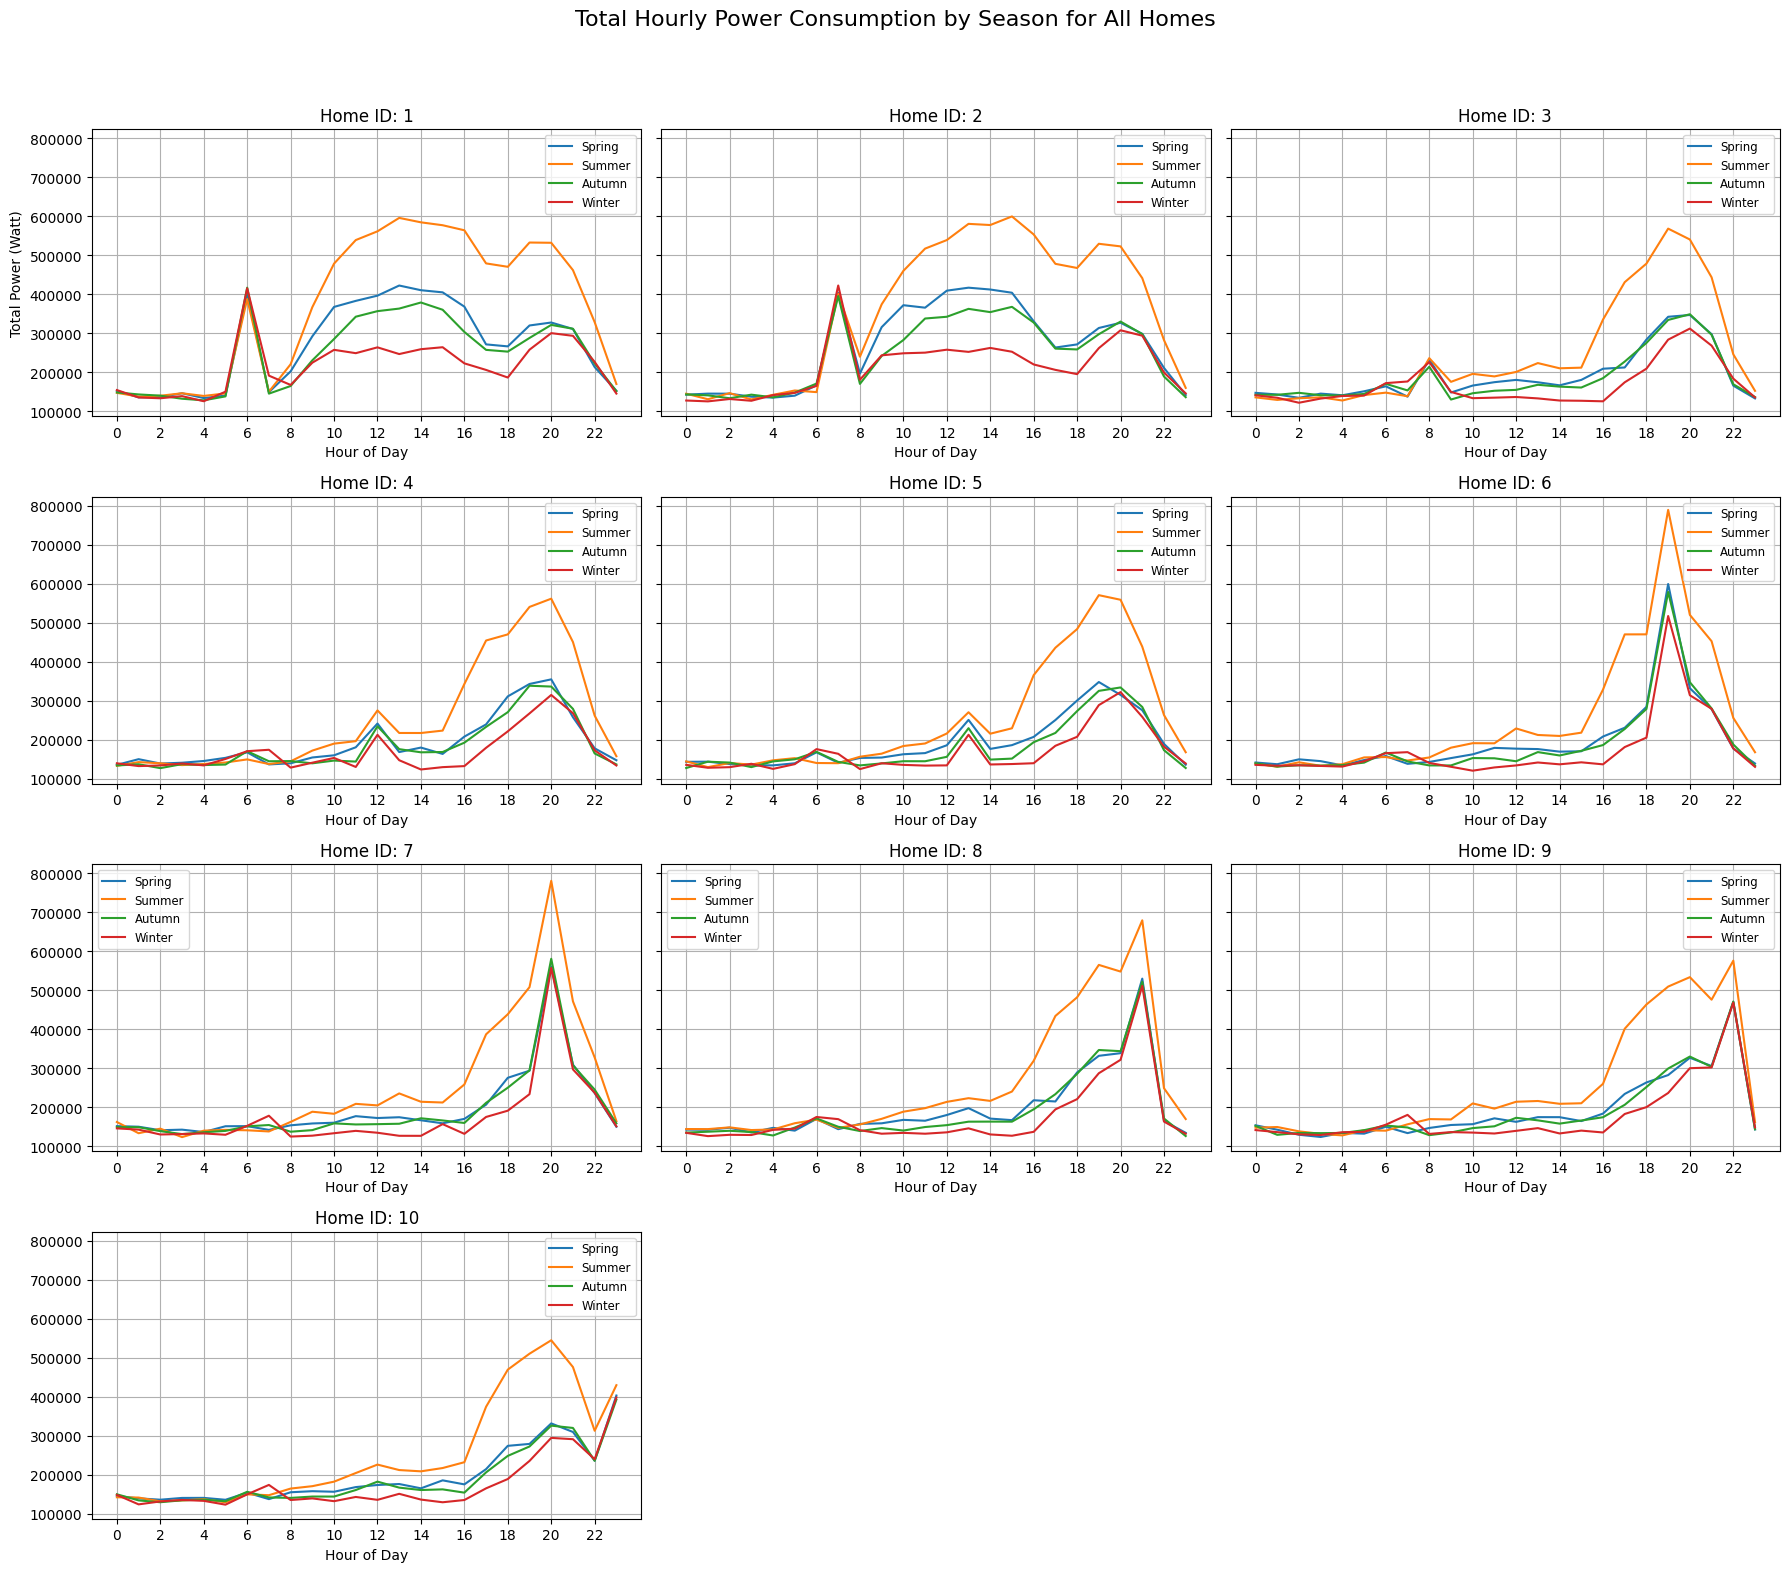

In [105]:
#@title Thói quen của từng hộ theo mùa
import pandas as pd
import matplotlib.pyplot as plt
import math

# Chuyển đổi timestamp và tạo cột mùa, giờ, tháng
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['month'] = df['timestamp'].dt.month
df['hour_of_day'] = df['timestamp'].dt.hour

def month_to_season(month):
    if month in [3,4,5]:
        return 'Spring'
    elif month in [6,7,8]:
        return 'Summer'
    elif month in [9,10,11]:
        return 'Autumn'
    else:
        return 'Winter'

df['season'] = df['month'].apply(month_to_season)

# Lấy danh sách home_id
home_ids = df['home_id'].unique()
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']

cols = 3
rows = math.ceil(len(home_ids) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharey=True)

# Nếu chỉ có 1 hàng thì axes không phải mảng 2 chiều, nên flatten hoặc xử lý cho thống nhất
if rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for i, home in enumerate(home_ids):
    ax = axes[i]
    df_home = df[df['home_id'] == home]
    total_power = df_home.groupby(['season', 'hour_of_day'])['power_watt'].sum().unstack(level=0)

    for season in seasons:
        if season in total_power.columns:
            ax.plot(total_power.index, total_power[season], label=season)

    ax.set_title(f"Home ID: {home}")
    ax.set_xlabel("Hour of Day")
    ax.set_xticks(range(0, 24, 2))
    ax.grid(True)
    ax.legend(fontsize='small')

# Với những subplot thừa (nếu có), tắt trục để đỡ thừa thãi
for j in range(len(home_ids), rows*cols):
    fig.delaxes(axes[j])

axes[0].set_ylabel("Total Power (Watt)")

plt.suptitle("Total Hourly Power Consumption by Season for All Homes", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


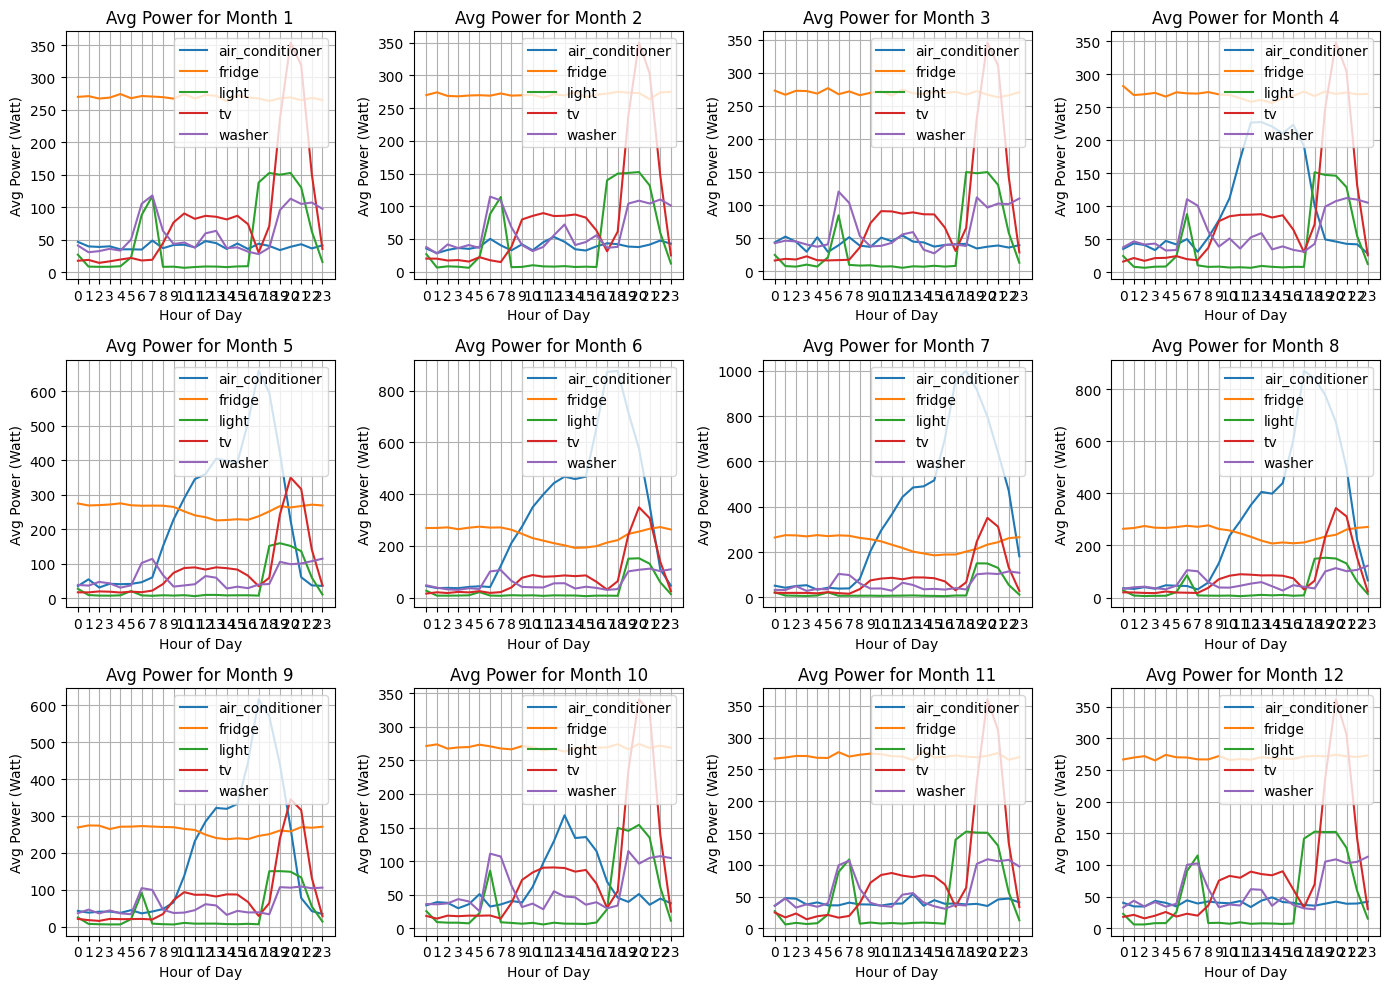

In [106]:
#@title Công suất tiêu thụ của các thiết bị theo giờ trong tháng
import pandas as pd
import matplotlib.pyplot as plt

# Giả sử df là DataFrame chứa dữ liệu

# Chuyển đổi cột 'timestamp' thành kiểu datetime nếu cần
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Thêm cột 'month' và 'hour_of_day' nếu chưa có
df['month'] = df['timestamp'].dt.month
df['hour_of_day'] = df['timestamp'].dt.hour

# Tính trung bình công suất theo từng giờ trong mỗi tháng và mỗi loại thiết bị
avg_power_by_hour_device = df.groupby(['month', 'hour_of_day', 'device_type'])['power_watt'].mean().unstack(level=[0, 2])

# Vẽ biểu đồ cho từng tháng
plt.figure(figsize=(14, 10))

for month in range(1, 13):
    plt.subplot(3, 4, month)

    # Lọc dữ liệu cho tháng cụ thể
    if month in avg_power_by_hour_device.columns.levels[0]:
        avg_power_by_hour = avg_power_by_hour_device[month]

        # Vẽ các đường cho từng loại thiết bị
        for device_type in avg_power_by_hour.columns:
            plt.plot(avg_power_by_hour.index, avg_power_by_hour[device_type], label=f"{device_type}")

        plt.title(f"Avg Power for Month {month}")
        plt.xlabel("Hour of Day")
        plt.ylabel("Avg Power (Watt)")
        plt.grid(True)
        plt.xticks(range(0, 24, 1))  # Nhãn theo từng giờ
        plt.legend(loc='upper right')
    else:
        plt.title(f"No data for Month {month}")
        plt.axis('off')  # Tắt trục nếu không có dữ liệu

plt.tight_layout()
plt.show()


# 3. Chọn mô hình (Model Selection & Evaluation)

In [7]:
!pip install  catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


## 3.1. Thử nghiệm với toàn bộ thuộc tính ban đầu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1205
[LightGBM] [Info] Number of data points in the train set: 1401600, number of used features: 17
[LightGBM] [Info] Start training from score 118.583912
LightGBM | MSE: 25337.36 | R2: 0.5359 | MAE: 56.82 | RMSE: 159.18 | Training Time: 7.84s | Prediction Time: 0.74s
Linear Regression | MSE: 47855.49 | R2: 0.1235 | MAE: 134.47 | RMSE: 218.76 | Training Time: 0.87s | Prediction Time: 0.03s
Decision Tree | MSE: 58193.77 | R2: -0.0659 | MAE: 72.73 | RMSE: 241.23 | Training Time: 27.68s | Prediction Time: 0.41s
XGBoost | MSE: 25353.16 | R2: 0.5356 | MAE: 56.19 | RMSE: 159.23 | Training Time: 9.07s | Prediction Time: 0.55s
CatBoost | MSE: 25248.28 | R2: 0.5375 | MAE: 55.83 | RMSE: 158.90 | Training Time: 18.74s | Prediction Time: 0.05s

Tổ

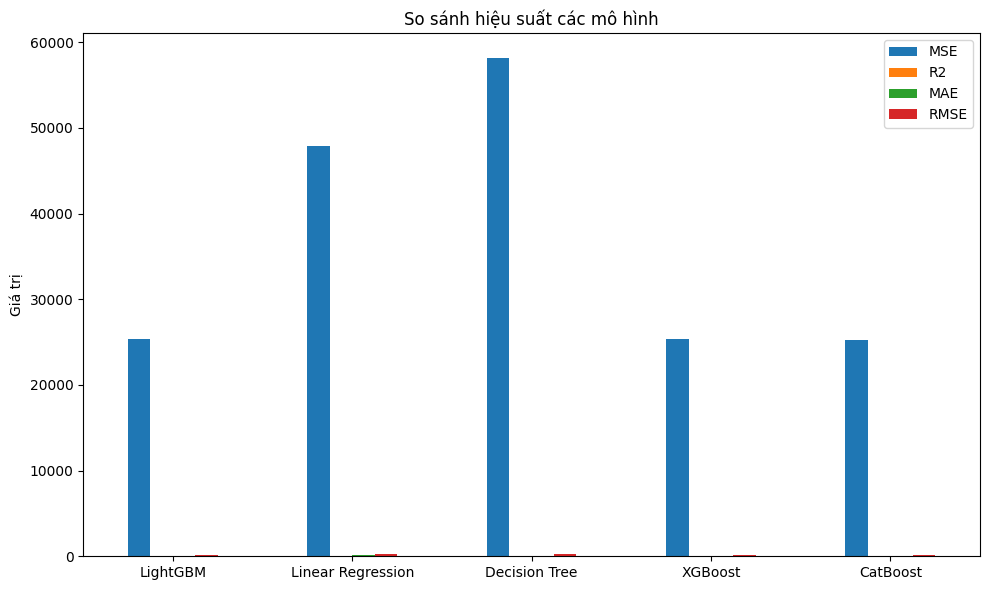

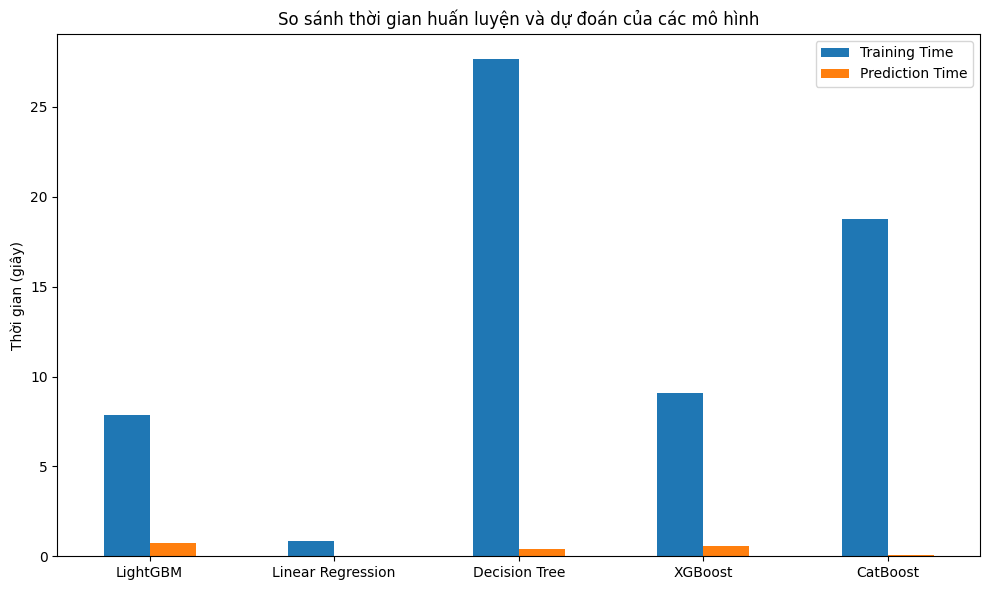

In [79]:
import pandas as pd
import time
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import catboost
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from datetime import timedelta
import time  # Thêm thư viện time để đo thời gian

# 1. Load và xử lý dữ liệu
df = pd.read_csv('data_2022.csv')
df = df.drop(columns=['status'])

# Xử lý cột timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df = df.drop(columns=['timestamp'])  # Loại bỏ cột timestamp ban đầu

# Xử lý các cột phân loại
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Chuyển đổi các cột phân loại thành các giá trị số (Label Encoding hoặc One-Hot Encoding)
label_encoders = {}
for col in categorical_cols:
    if df[col].dtype == 'object':  # Kiểm tra cột có phải là object không
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Tách dữ liệu đầu vào và mục tiêu
X = df.drop(columns=['power_watt'])
y = df['power_watt']

# 2. Tạo pipeline tiền xử lý
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols)
])

# --- 3. Các mô hình để so sánh ---
models = {
    'LightGBM': lgb.LGBMRegressor(objective='regression', n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    'CatBoost': catboost.CatBoostRegressor(iterations=100, random_seed=42, verbose=0)  # CatBoost không cần chuyển đổi nhãn như LightGBM
}
# --- 5. Tách tập train/test ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 6. Hàm huấn luyện và đánh giá mô hình ---
def train_and_evaluate_model(name, model):
    start_time = time.time()  # Bắt đầu thời gian huấn luyện
    model.fit(X_train, y_train)
    training_time = time.time() - start_time  # Thời gian huấn luyện

    start_time_pred = time.time()  # Bắt đầu thời gian dự đoán
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time_pred  # Thời gian dự đoán

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Root Mean Squared Error

    # In ra thời gian và các chỉ số
    print(f"{name} | MSE: {mse:.2f} | R2: {r2:.4f} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | Training Time: {training_time:.2f}s | Prediction Time: {prediction_time:.2f}s")

    return mse, r2, mae, rmse, training_time, prediction_time

# --- 8. Huấn luyện và đánh giá các mô hình ---
results = {}
for name, model in models.items():
    mse, r2, mae, rmse, training_time, prediction_time = train_and_evaluate_model(name, model)
    results[name] = {'MSE': mse, 'R2': r2, 'MAE': mae, 'RMSE': rmse, 'Training Time': training_time, 'Prediction Time': prediction_time}

# --- 9. Hiển thị kết quả ---
results_df = pd.DataFrame(results).T
print("\nTổng hợp kết quả các mô hình:")
print(results_df)

# --- 10. Vẽ biểu đồ so sánh các mô hình ---
results_df[['MSE', 'R2', 'MAE', 'RMSE']].plot(kind='bar', figsize=(10, 6))
plt.title("So sánh hiệu suất các mô hình")
plt.ylabel("Giá trị")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 11. Vẽ biểu đồ thời gian huấn luyện và dự đoán ---
results_df[['Training Time', 'Prediction Time']].plot(kind='bar', figsize=(10, 6))
plt.title("So sánh thời gian huấn luyện và dự đoán của các mô hình")
plt.ylabel("Thời gian (giây)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1205
[LightGBM] [Info] Number of data points in the train set: 1401600, number of used features: 17
[LightGBM] [Info] Start training from score 118.583912


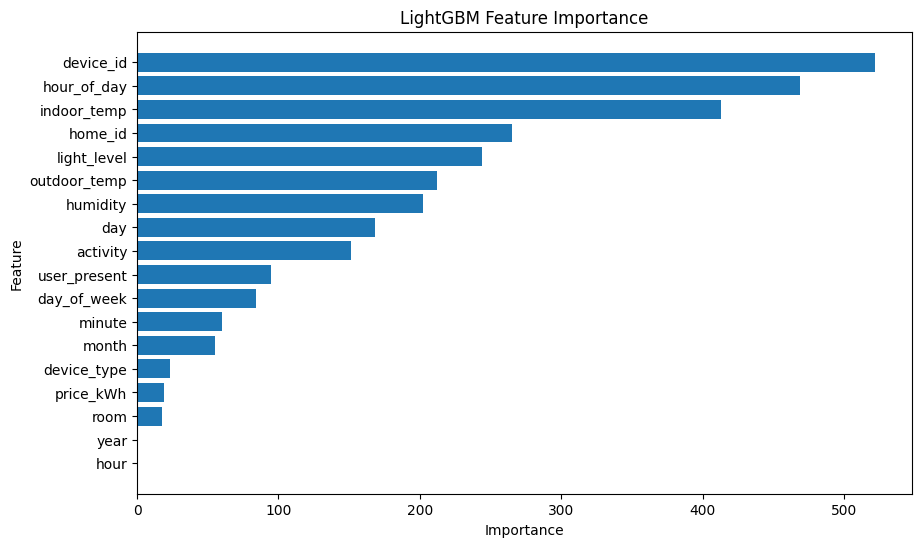

In [80]:
# --- Sau khi huấn luyện mô hình LightGBM ---
lgb_model = models['LightGBM']
lgb_model.fit(X_train, y_train)

# --- 1. Vẽ biểu đồ Feature Importance ---
importances = lgb_model.feature_importances_
feature_names = X_train.columns

# Tạo DataFrame chứa tên và độ quan trọng
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.gca().invert_yaxis()
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Nhận xét:
Dưới đây là nhận xét tổng quan dựa trên kết quả thử nghiệm với toàn bộ tập **feature** trên các mô hình hồi quy:

---

### **1. Hiệu suất dự đoán:**

* **CatBoost** cho kết quả **tốt nhất** về tổng thể, đạt:
  * **MSE thấp nhất (25353.164815)**,
  * **R² cao nhất (0.535624)**,
  * **MAE thấp nhất (56.190543)**,
  * **RMSE thấp nhất (159.226772)**.
    → Điều này cho thấy CatBoost có khả năng mô hình hóa mối quan hệ phức tạp giữa các đặc trưng và biến mục tiêu một cách hiệu quả.

* **XGBoost** và **LightGBM** có hiệu suất gần tương đương, với các chỉ số MSE, R², MAE, RMSE chỉ chênh lệch nhẹ so với CatBoost.
  → Đây là hai mô hình mạnh và đáng tin cậy, đặc biệt phù hợp khi cần cân bằng giữa tốc độ huấn luyện và độ chính xác.

* **Linear Regression** có R² chỉ đạt **0.104**, tức là mô hình chỉ giải thích được 10.4% phương sai của dữ liệu. Đây là kết quả **rất yếu**, phản ánh tính **không tuyến tính** trong dữ liệu mà mô hình tuyến tính không thể nắm bắt.

* **Decision Tree** cho kết quả **tệ nhất**, với R² âm (**-0.283**), MSE và RMSE đều cao. Điều này cho thấy cây quyết định đang bị **overfit nghiêm trọng** hoặc không đủ sâu để khai thác hết thông tin từ dữ liệu.

---

### **2. Tốc độ huấn luyện và dự đoán:**

* **Linear Regression** có thời gian huấn luyện và dự đoán **nhanh nhất**. Tuy nhiên, điều này đánh đổi bằng hiệu suất thấp.

* **LightGBM** và **XGBoost** huấn luyện khá nhanh (8–10 giây) và dự đoán nhanh, trong khi vẫn duy trì độ chính xác cao.

* **CatBoost** cần nhiều thời gian hơn để huấn luyện (18.4s), nhưng vẫn ở mức chấp nhận được nếu đổi lại là hiệu suất tốt nhất.

* **Decision Tree** có thời gian huấn luyện dài (**26.8s**) nhưng hiệu suất thấp, không đáng để lựa chọn trong trường hợp này.

---

### **3. Tổng kết và khuyến nghị:**

* **CatBoost** là lựa chọn hàng đầu khi ưu tiên hiệu quả dự đoán.
* **XGBoost** và **LightGBM** là các phương án thay thế tốt nếu cần tốc độ huấn luyện/dự đoán nhanh hơn một chút.
* **Linear Regression** và **Decision Tree** nên được loại bỏ hoặc chỉ dùng làm baseline.

=> Nên **feature selection** hoặc **feature engineering** thêm để cải thiện hiệu suất hơn nữa, dù hiện tại các mô hình boosting đã khai thác khá tốt đặc trưng.


##3.2. Thử nghiệm với thuộc tính mới - yếu tố thói quen sinh hoạt trong dữ liệu lịch sử

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 1401600, number of used features: 12
[LightGBM] [Info] Start training from score 118.583912
LightGBM | MSE: 11954.06 | R2: 0.7810 | MAE: 35.20 | RMSE: 109.33 | Training Time: 10.99s | Prediction Time: 0.78s
Linear Regression | MSE: 40703.57 | R2: 0.2545 | MAE: 127.46 | RMSE: 201.75 | Training Time: 0.52s | Prediction Time: 0.02s
Decision Tree | MSE: 21531.57 | R2: 0.6056 | MAE: 30.29 | RMSE: 146.74 | Training Time: 15.42s | Prediction Time: 0.37s
XGBoost | MSE: 11923.77 | R2: 0.7816 | MAE: 31.51 | RMSE: 109.20 | Training Time: 12.43s | Prediction Time: 0.51s
CatBoost | MSE: 11913.23 | R2: 0.7818 | MAE: 34.91 | RMSE: 109.15 | Training Time: 19.21s | Prediction Time: 0.05s

T

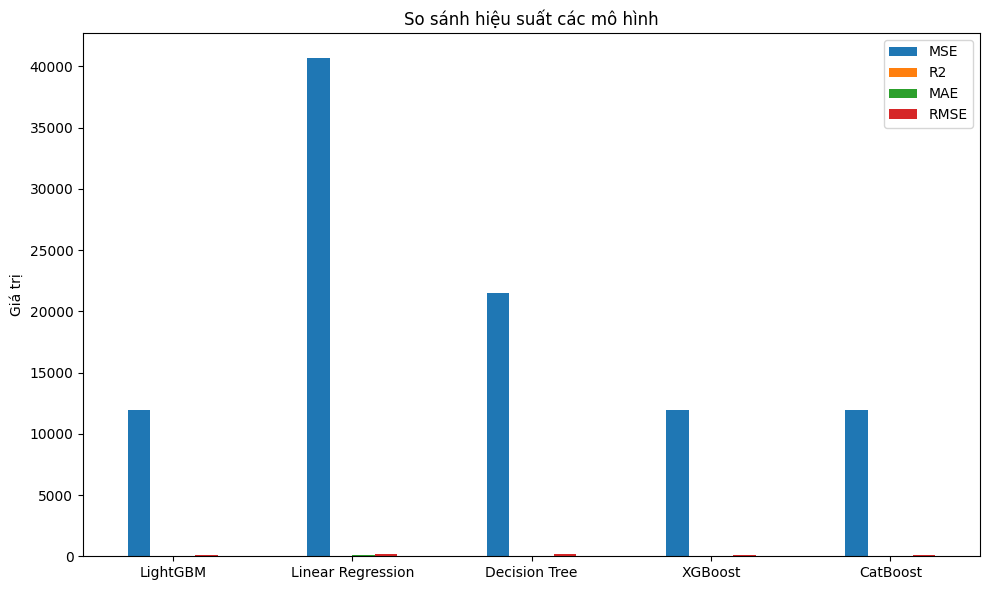

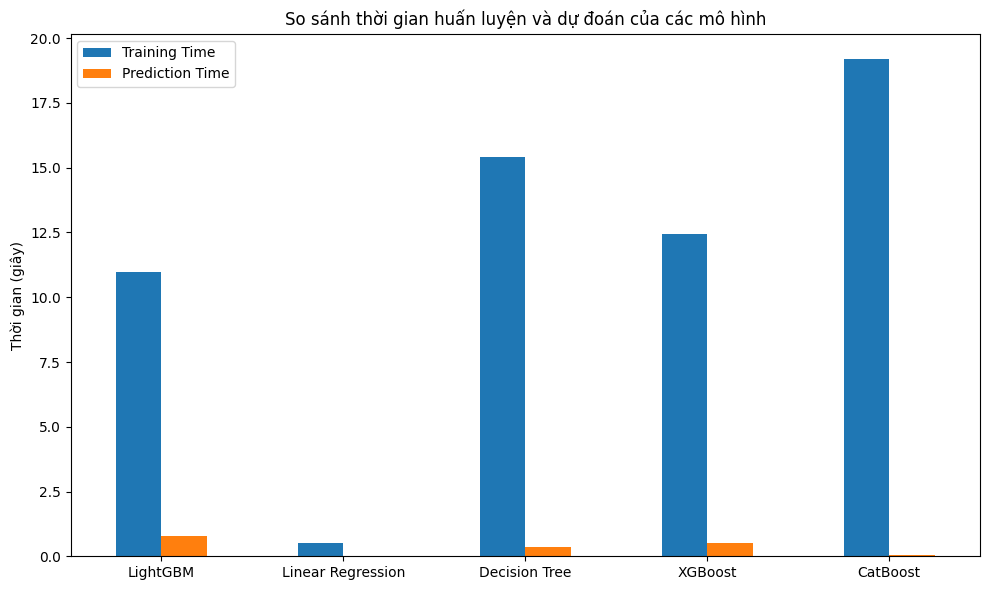

In [75]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from datetime import timedelta

# Tiền xử lý dữ liệu
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Đánh giá mô hình
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mô hình
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


# --- 1. Đọc dữ liệu ---
df = pd.read_csv('data_2022.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# --- 2. Hàm feature engineering ---
def feature_engineering(df):
    df = df.copy()
    df['timestamp_yesterday'] = df['timestamp'] - pd.Timedelta(days=2)
    df['total_power_home_yesterday'] = df.groupby(['home_id', 'timestamp_yesterday'])['power_watt'].transform('sum')
    df = df.drop(columns=['status', 'timestamp', 'device_id', 'timestamp_yesterday', 'price_kWh'])
    return df

# --- 3. Áp dụng feature engineering ---
df_fe = feature_engineering(df)

# --- 4. Chuẩn bị dữ liệu ---
target = 'power_watt'
X = df_fe.drop(columns=[target])
y = df_fe[target]

# Mã hoá các cột phân loại
categorical_cols = X.select_dtypes(include='object').columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# --- 5. Tách tập train/test ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 6. Khởi tạo các mô hình ---
models = {
    'LightGBM': lgb.LGBMRegressor(objective='regression', n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    'CatBoost': catboost.CatBoostRegressor(iterations=100, random_seed=42, verbose=0)  # CatBoost không cần chuyển đổi nhãn như LightGBM
}

# --- 6. Hàm huấn luyện và đánh giá mô hình ---
def train_and_evaluate_model(name, model):
    start_time = time.time()  # Bắt đầu thời gian huấn luyện
    model.fit(X_train, y_train)
    training_time = time.time() - start_time  # Thời gian huấn luyện

    start_time_pred = time.time()  # Bắt đầu thời gian dự đoán
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time_pred  # Thời gian dự đoán

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Root Mean Squared Error

    # In ra thời gian và các chỉ số
    print(f"{name} | MSE: {mse:.2f} | R2: {r2:.4f} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | Training Time: {training_time:.2f}s | Prediction Time: {prediction_time:.2f}s")

    return mse, r2, mae, rmse, training_time, prediction_time

# --- 8. Huấn luyện và đánh giá các mô hình ---
results = {}
for name, model in models.items():
    mse, r2, mae, rmse, training_time, prediction_time = train_and_evaluate_model(name, model)
    results[name] = {'MSE': mse, 'R2': r2, 'MAE': mae, 'RMSE': rmse, 'Training Time': training_time, 'Prediction Time': prediction_time}

# --- 9. Hiển thị kết quả ---
results_df = pd.DataFrame(results).T
print("\nTổng hợp kết quả các mô hình:")
print(results_df)

# --- 10. Vẽ biểu đồ so sánh các mô hình ---
results_df[['MSE', 'R2', 'MAE', 'RMSE']].plot(kind='bar', figsize=(10, 6))
plt.title("So sánh hiệu suất các mô hình")
plt.ylabel("Giá trị")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 11. Vẽ biểu đồ thời gian huấn luyện và dự đoán ---
results_df[['Training Time', 'Prediction Time']].plot(kind='bar', figsize=(10, 6))
plt.title("So sánh thời gian huấn luyện và dự đoán của các mô hình")
plt.ylabel("Thời gian (giây)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 1401600, number of used features: 12
[LightGBM] [Info] Start training from score 118.583912


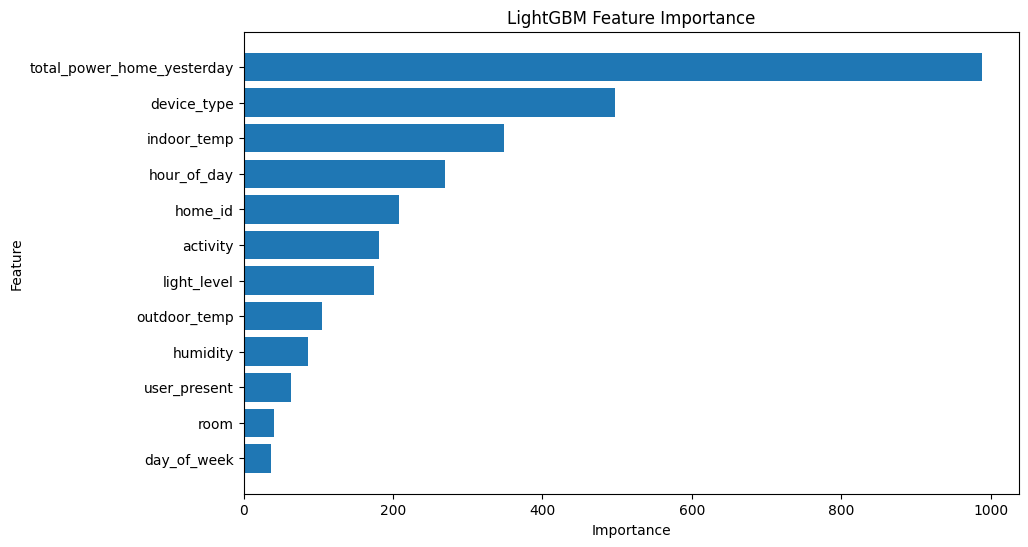

In [77]:
# --- Sau khi huấn luyện mô hình LightGBM ---
lgb_model = models['LightGBM']
lgb_model.fit(X_train, y_train)

# --- 1. Vẽ biểu đồ Feature Importance ---
importances = lgb_model.feature_importances_
feature_names = X_train.columns

# Tạo DataFrame chứa tên và độ quan trọng
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.gca().invert_yaxis()
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


---

###**Nhận xét sau khi áp dụng `feature_engineering()` với đặc trưng tổng công suất ngày hôm trước:**

####Hiệu quả mô hình được cải thiện rõ rệt:

| Mô hình               | R² Trước | R² Sau     | RMSE Trước | RMSE Sau   | Mức cải thiện     |
| --------------------- | -------- | ---------- | ---------- | ---------- | ----------------- |
| **LightGBM**          | 0.5359   | **0.7810** | 159.18     | **109.33** | **Rất tốt**       |
| **XGBoost**           | 0.5356   | **0.7816** | 159.22     | **109.19** | **Rất tốt**       |
| **CatBoost**          | 0.5375   | **0.7818** | 158.89     | **109.14** | **Rất tốt**       |
| **Decision Tree**     | -0.0659  | **0.6056** | 241.23     | **146.73** | **Cải thiện lớn** |
| **Linear Regression** | 0.1235   | 0.2545     | 218.76     | 201.75     | Cải thiện nhẹ     |

---

### **Ý nghĩa của đặc trưng mới:**

* Biến `total_power_home_yesterday` giúp mô hình khai thác **mối quan hệ theo thời gian** (temporal dependency) giữa mức tiêu thụ ngày hôm trước và hiện tại.
* Điều này rất hữu ích với các bài toán dự báo (forecasting) hoặc hồi quy thời gian thực, đặc biệt trong lĩnh vực năng lượng điện.

---

###**Tóm tắt:**

* Feature engineering với đặc trưng có yếu tố **dạng thời gian (lag feature)** đã **nâng cao đáng kể hiệu năng của các mô hình phức tạp như LightGBM, XGBoost, và CatBoost**.
* Việc loại bỏ các cột dư thừa (`status`, `timestamp`, `device_id`, `price_kWh`,...) cũng giúp giảm nhiễu cho mô hình.
* Đây là bước quan trọng giúp **chuyển từ một bộ đặc trưng thô sang một bộ đặc trưng mang thông tin giàu giá trị** cho học máy.

---
